In [1]:
import torch
import torchvision
import matplotlib
import cv2
print("torch version: ",torch.__version__)
print("torchvision version: ",torchvision.__version__)
print("cuda available: ", torch.cuda.is_available())
print("matplotlib version", matplotlib.__version__)
print("cuda version", torch.version.cuda)
print("opencv version", cv2.__version__)

torch version:  2.0.1
torchvision version:  0.15.2
cuda available:  True
matplotlib version 3.8.2
cuda version 11.7
opencv version 4.8.1


In [2]:
# import cv2
# import numpy as np

# # 读取图像
# image = cv2.imread('path_to_your_image.jpg')

# # 将图像从RGB转换到HSV颜色空间
# image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# # 对每个通道计算归一化直方图
# hist_h = cv2.calcHist([image_hsv], [0], None, [256], [0, 256]) / image.size
# hist_s = cv2.calcHist([image_hsv], [1], None, [256], [0, 256]) / image.size
# hist_v = cv2.calcHist([image_hsv], [2], None, [256], [0, 256]) / image.size

# # hist_h, hist_s, hist_v分别是色调、饱和度和亮度通道的归一化直方图


In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import transforms

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from torchvision.io import read_image
from utils.mydataset import MyDataset

# 自定义数据集
class CustomDataset(Dataset):
    def __init__(self, input_folder, truth_folder, transform=None):
        self.input_folder = input_folder
        self.truth_folder = truth_folder
        self.transform = transform
        self.image_filenames = os.listdir(input_folder)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        input_image = (read_image(os.path.join(self.input_folder, self.image_filenames[idx])))/255.0
        truth_image = (read_image(os.path.join(self.truth_folder, self.image_filenames[idx])))/255.0

        if self.transform:
            input_image = self.transform(input_image)
            truth_image = self.transform(truth_image)

        return input_image, truth_image

transform = transforms.Compose([
    transforms.Resize((256,256)),
])

# 得到一个dataset对象
train_dataset = MyDataset(input_folder='train', truth_folder='train_truth',transform=transform)

# 封装成一个可iterate的对象dataloader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [5]:
train_dataset.__len__()

3879

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 从数据加载器中获取一个批次的图像
dataiter = iter(train_loader)
images, labels = next(dataiter)


e:\anaconda3\envs\inpainting-basic\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


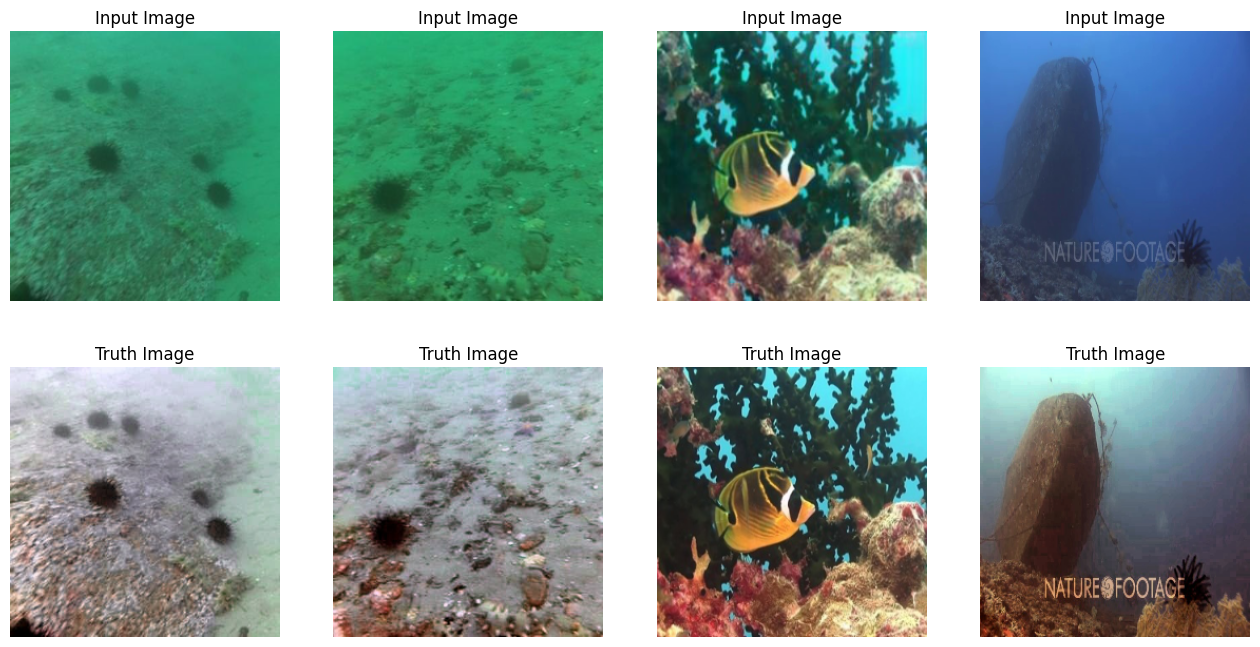

tensor([[[0.2239, 0.2239, 0.2239,  ..., 0.1683, 0.1683, 0.1683],
         [0.2264, 0.2264, 0.2264,  ..., 0.1637, 0.1637, 0.1637],
         [0.2218, 0.2218, 0.2218,  ..., 0.1574, 0.1574, 0.1574],
         ...,
         [0.0840, 0.0807, 0.0785,  ..., 0.1733, 0.1740, 0.1697],
         [0.0815, 0.0786, 0.0739,  ..., 0.1692, 0.1696, 0.1710],
         [0.0787, 0.0754, 0.0729,  ..., 0.1650, 0.1656, 0.1714]],

        [[0.6788, 0.6788, 0.6788,  ..., 0.6820, 0.6820, 0.6820],
         [0.6813, 0.6813, 0.6813,  ..., 0.6774, 0.6774, 0.6774],
         [0.6767, 0.6767, 0.6767,  ..., 0.6711, 0.6711, 0.6711],
         ...,
         [0.2202, 0.2141, 0.2119,  ..., 0.6151, 0.6171, 0.6129],
         [0.2127, 0.2090, 0.2044,  ..., 0.6124, 0.6128, 0.6141],
         [0.2081, 0.2048, 0.2023,  ..., 0.6082, 0.6087, 0.6146]],

        [[0.5258, 0.5258, 0.5258,  ..., 0.5487, 0.5487, 0.5487],
         [0.5284, 0.5284, 0.5284,  ..., 0.5441, 0.5441, 0.5441],
         [0.5238, 0.5238, 0.5238,  ..., 0.5378, 0.5378, 0.

In [7]:


# 显示批次中的前几个图像对
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for i in range(4):
    ax[0, i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax[0, i].set_title('Input Image')
    ax[0, i].axis('off')
    
    ax[1, i].imshow(np.transpose(labels[i].numpy(), (1, 2, 0)))
    ax[1, i].set_title('Truth Image')
    ax[1, i].axis('off')
plt.show()

print(images[0])



In [6]:
from network.network import SimpleAutoencoder

net = SimpleAutoencoder()

In [7]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

model_save_dir = "weights"
# 如果目录不存在，则创建目录
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    # 包装train_loader到tqdm中
    with tqdm(train_loader, unit="batch") as tepoch:
        for inputs, targets in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)

            # 计算损失
            loss = criterion(outputs, targets)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 在tqdm进度条中显示当前批次的损失
            tepoch.set_postfix(loss=loss.item())

    # 每隔5个epoch保存模型
    if (epoch + 1) % 5 == 0:
        model_path = os.path.join(model_save_dir, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at epoch {epoch+1} in {model_path}")


  0%|          | 0/970 [00:00<?, ?batch/s]e:\anaconda3\envs\inpainting-basic\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epoch 5: 100%|██████████| 970/970 [00:56<00:00, 17.24batch/s, loss=0.0242] 


Model saved at epoch 5 in weights\model_epoch_5.pth


Epoch 10: 100%|██████████| 970/970 [00:55<00:00, 17.61batch/s, loss=0.00848]


Model saved at epoch 10 in weights\model_epoch_10.pth


In [8]:
model_eval = model.eval()

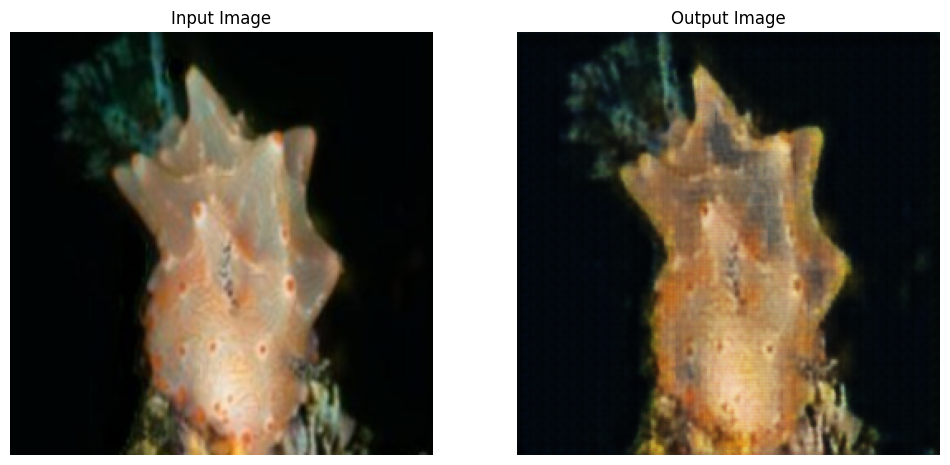

In [9]:
import matplotlib.pyplot as plt
import torch

# 确保模型处于评估模式
model.eval()

# 从数据加载器中获取一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 选择批次中的第一个图像进行测试
input_image = images[0].unsqueeze(0).to(device)  # 添加批次维度，并传输到设备

# 使用模型进行前向传播获取输出图像
with torch.no_grad():  # 确保不计算梯度
    output_image = model(input_image)

# 将输出张量转换回图像数据的范围[0, 1]（如果你的输出使用了激活函数如Sigmoid，则可能已经在这个范围内）
output_image = output_image.squeeze(0).cpu().numpy()  # 移除批次维度，并转换为numpy数组
output_image = np.transpose(output_image, (1, 2, 0))  # 调整维度顺序为[H, W, C]

# 输入图像的处理
input_image_vis = images[0].numpy()
input_image_vis = np.transpose(input_image_vis, (1, 2, 0))  # 调整维度顺序为[H, W, C]

# 可视化输入和输出图像
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_image_vis)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Output Image')
plt.axis('off')

plt.show()


In [10]:
%pip install scikit-image

  Using cached scikit_image-0.22.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl.metadata (4.3 kB)
Using cached scikit_image-0.22.0-cp311-cp311-win_amd64.whl (24.5 MB)
   ---------------------------------------- 0.0/313.4 kB ? eta -:--:--
   ---------------------------------------- 313.4/313.4 kB 9.8 MB/s eta 0:00:00
Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
   ---------------------------------------- 0.0/224.5 kB ? eta -:--:--
   ---------------------------------------- 224.5/224.5 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
